前面我们用遗传算法动手做了两个实验，本篇文章我们再用遗传算法做一个实验：用遗传算法求解TSP。

在这个问题中，我们的个体就是一条一条的路线了，其目的就是找到一条总距离最短的路线。基本步骤与前两篇文章基本类似，不过在本问题中，我们用城市路线中每个城市的经纬度来表示个体(城市路线)的DNA。

在产生后代的过程中，需要注意的是，因为我们的个体是路线，所以我们不能够像前两篇文章一样将两个父本的样本进行随机交换，因为如果随机交换，就会出现路线重复的问题，比如说，有两个父本[2,1,0,3]和[3,0,1,2]，若将第一个元素进行交换得到一个后代[3,1,0,3]或者[2,0,1,2]，这就表示去过3号城市去了两次或2号城市去了两次，明显不合理。这里我们用了一个简单技巧，比如说我们先取[2,1]，然后再到另一个父本中去掉[2,1]之后的剩下的城市，同时保持其顺序，即从父本中取出的是[3,0]，然后concat就得到了一个后代[2,1,3,0]。详细代码如下：

```
def create_child(self, parent, population):
    if np.random.rand() < self.cross_rate:
        index = np.random.randint(0, self.n_population, size=1)
        cross_points = np.random.randint(0, 2, self.DNA_size).astype(np.bool)
        dad_DNA = parent[cross_points]
        mom_DNA = population[index, np.isin(population[index].ravel(), dad_DNA, invert=True)]
        parent = np.hstack((dad_DNA, mom_DNA))
        #child = parent
    return parent
```


还有，基因突变的时候也会与以前不一样，假设我们现在已经得到了一个后代[2,1,3,0]，我们现在要对其进行基因突变，如果我们将1变成了0，那么我们也要将0变1，否则就会出现上面刚刚说到的问题，即城市名重复问题。

```
def mutate_child(self, child):
    for i in range(self.DNA_size):
        if np.random.rand() < self.mutate_rate:
            child = self.swap(i, child)
    return child

def swap(self, i, child):
    new_value = np.random.randint(0, self.DNA_size)
    j = np.argwhere(child == new_value)[0][0]
    child[j] = child[i]
    child[i] = new_value
    return child
```





其它的就不多说了，全文代码如下：

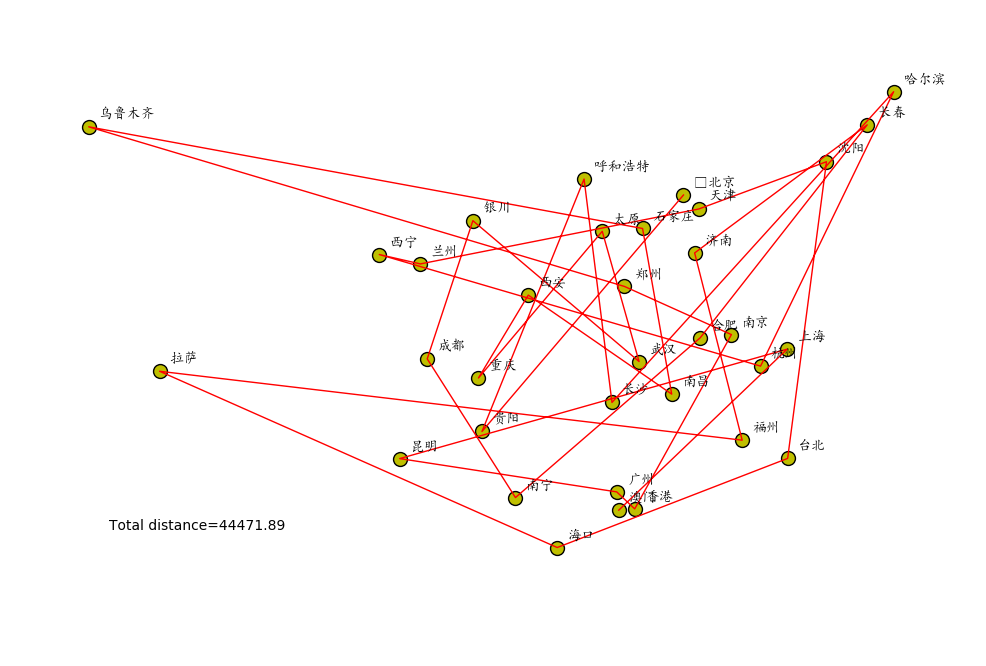

In [1]:
import numpy as np
from math import radians, cos, sin, asin, sqrt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sys
reload(sys)
sys.setdefaultencoding('utf8')


class GeneticAlgorithm(object):
    """遗传算法.

    Parameters:
    -----------
    cross_rate: float
        交配的可能性大小.
    mutate_rate: float
        基因突变的可能性大小. 
    n_population: int
        种群的大小.
    n_iterations: int
        迭代次数.
    DNA_size: int
        DNA的长度.
    n_cities: int
        城市个数.
    """
    def __init__(self, cross_rate, mutation_rate, n_population, n_iterations, n_cities):
        self.cross_rate = cross_rate
        self.mutate_rate = mutation_rate
        self.n_population = n_population
        self.n_iterations = n_iterations
        self.DNA_size = n_cities
        self.n_cities = n_cities
        

    # 初始化一个种群
    def init_population(self):
        population = np.array([np.random.permutation(self.DNA_size) for _ in np.arange(self.n_population)]).astype(np.int8)
        return population


    # 将个体的DNA转换成ASCII
    def translateDNA(self, population, longitudes_latitudes):
        longitudes = np.empty_like(population, dtype=np.float64)
        latitudes = np.empty_like(population, dtype=np.float64)
        for i, person in enumerate(population):
            longitude_latitude = longitudes_latitudes[person]
            longitudes[i, :] = longitude_latitude[:, 0]
            latitudes[i, :] = longitude_latitude[:, 1]
            
        return longitudes, latitudes

    # 计算种群中每个个体的适应度，适应度越高，说明该个体的基因越好
    def fitness(self, population, longitudes, latitudes):
        total_distances = np.empty((longitudes.shape[0],), dtype=np.float64)
        for i in range(population.shape[0]):
            # 方法一: 用欧氏距离计算
            # total_distance = np.sum( np.power(np.diff(longitudes[i]), 2) + np.power(np.diff(latitudes[i]), 2) )
            
            # 方法二: 用球面距离计算
            total_distance = 0
            for j in range(population.shape[1] - 1):
                total_distance = total_distance + self.haversine(longitudes[i][j], latitudes[i][j], longitudes[i][j+1], latitudes[i][j+1] )
            
            
            total_distances[i] = total_distance
        fitness_score = np.exp(1/(total_distances + 1e-4))
        return fitness_score, total_distances
    
    def haversine(self, lon1, lat1, lon2, lat2):
        """
        Calculate the great circle distance between two points
        on the earth (specified in decimal degrees)
        
        参数: 经度1, 纬度1, 经度2, 纬度2 (十进制度数)
        """ 
        # 将十进制度数转化为弧度  
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])  
        
        # haversine公式  
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        r = 6371 # 地球平均半径，单位为公里
        return c * r

    # 对种群按照其适应度进行采样，这样适应度高的个体就会以更高的概率被选择
    def select(self, population, fitness_score):
        
        idx = np.random.choice(np.arange(self.n_population), size=self.n_population, replace=True, p=fitness_score/fitness_score.sum())
        return population[idx]

    # 进行交配
    def create_child(self, parent, population):
        if np.random.rand() < self.cross_rate:
            index = np.random.randint(0, self.n_population, size=1)
            cross_points = np.random.randint(0, 2, self.DNA_size).astype(np.bool)
            dad_DNA = parent[cross_points]
            mom_DNA = population[index, np.isin(population[index].ravel(), dad_DNA, invert=True)]
            parent = np.hstack((dad_DNA, mom_DNA))
            #child = parent
        return parent

    # 基因突变
    def mutate_child(self, child):
        for i in range(self.DNA_size):
            if np.random.rand() < self.mutate_rate:
                child = self.swap(i, child)
        return child
    
    def swap(self, i, child):
        new_value = np.random.randint(0, self.DNA_size)
        j = np.argwhere(child == new_value)[0][0]
        child[j] = child[i]
        child[i] = new_value
        return child
        

    # 进化
    def evolution(self, longitudes_latitudes):
        population = self.init_population()
        longitudes, latitudes = self.translateDNA(population, longitudes_latitudes)
        #print(population.shape)
        for i in range(self.n_iterations):
            fitness_score, total_distances = self.fitness(population, longitudes, latitudes)
            #print(fitness_score)
            best_person = population[np.argmax(fitness_score)]
            best_person = best_person.reshape(-1, best_person.shape[0])
            
            best_person_longitude, best_person_latitude = self.translateDNA(best_person, longitudes_latitudes)
            
            best_person_fitness_score, best_person_distance = self.fitness(best_person, best_person_longitude, best_person_latitude)
            
            if i % 100 == 0:
                print(u'第%-4d次进化后, 基因最好的个体(最好的路线)是: %s, 其总距离为: %-4.2f 公里'% (i, str(best_person[0]), 
                                                                            best_person_distance))
            if i == self.n_iterations - 1:
                print('')
                print(u'遗传算法找到的基因最好的个体(最好的路线)是: %s, 其总距离为: %-4.2f 公里'% (str(cities[best_person][0]), 
                                                                            best_person_distance) )
                
                
            population = self.select(population, fitness_score)
            population_copy = population.copy()
            #print(population.shape)
            for parent in population:
                child = self.create_child(parent, population_copy)
                #print(child)
                child = self.mutate_child(child)
                parent[:] = child
                
            population = population
        self.best_person = best_person
        self.best_person_distance = best_person_distance
        self.best_person_longitude = best_person_longitude
        self.best_person_latitude = best_person_latitude
        
def main():
    # 加载数据集
    #longitudes_latitudes = np.random.rand(n_cities, 2)
    data = pd.read_csv('F:/work/Machine-learning-implement/data/china.csv', sep=';', header=None)
    global cities
    cities = data.ix[:, 0].values
    n_cities = cities.shape[0]
    
    longitudes_latitudes = data.ix[:, 1:].values
    
    
    ga = GeneticAlgorithm(cross_rate=0.8, mutation_rate=0.01, n_population=100, n_iterations=500, n_cities=n_cities)
    
    ga.evolution(longitudes_latitudes)
    
    plt.figure(figsize=(12, 8))
    zhfont1 = matplotlib.font_manager.FontProperties(fname='C:\Windows\Fonts\simkai.ttf')
    plt.scatter(longitudes_latitudes[:, 0], longitudes_latitudes[:, 1], s=100, c='y')
    
    for i in range(ga.best_person_longitude.shape[1]):
        plt.text(ga.best_person_longitude[0][i] + 0.5, ga.best_person_latitude[0][i] + 0.5, "%s" % cities[ga.best_person][0][i], 
                 fontdict={'size': 12, 'color': 'k'}, fontproperties=zhfont1)
    
    plt.plot(ga.best_person_longitude[0], ga.best_person_latitude[0], 'r-')
    plt.text(ga.best_person_longitude[0].min()+1, ga.best_person_latitude[0].min()+1, 
         "Total distance=%.2f" % ga.best_person_distance, fontdict={'size': 10, 'color': 'k'})

    plt.axis('off')
    plt.show()
    
    
if __name__ == '__main__':
    main()
